<a href="https://colab.research.google.com/github/ericalmon/Shopify-Data-Science-Challenge-2021-Fall/blob/main/Shopify_Technical_Challenge_Submission_Fall_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install outlier_utils

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')
PATH = "/content/drive/MyDrive/Colab Notebooks/Shopify_2021_Fall"
%cd /content/drive/MyDrive/Colab Notebooks/Shopify_2021_Fall

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Shopify_2021_Fall


Immediately, I take issue with how AOV is used as there are transactions across multiple shops instead of one shop with similiarly price items (such as a beauty products, for example).

We'll first use the describe() function to give a high level overview of the data. From first blush, there seems to be an extreme outlier at 704,000 under "order_amount". 

In [4]:
df = pd.read_excel('Shopify_dataset.xlsx')
df.describe(percentiles=[.25, .5, .75, .95])['order_amount']

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
95%         640.000000
max      704000.000000
Name: order_amount, dtype: float64

Let's visualize the order amount dataset. 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d92d088d0>]],
      dtype=object)

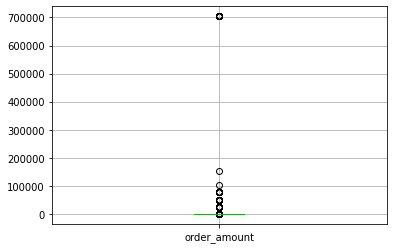

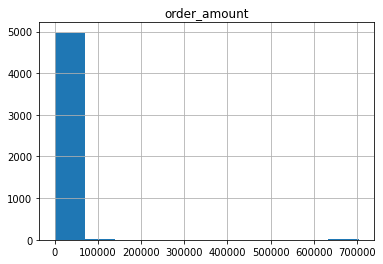

In [5]:
df.boxplot(column='order_amount')
df.hist(column='order_amount', bins=10)

It seems as though there are large outliers in the order amount data. However, it is important to notet that "order_amount" represents the total dollar value of an order, regardless of how many items are created. Could the outliers be explained by large item volumes?

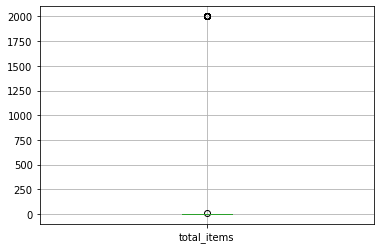

In [6]:
#visualize orders
df.boxplot(column='total_items')

It appears someone has ordered a large amount of shoes in single orders, which heavily skews the data. Let's take a look at the order amount with 2000 items.

In [7]:
df.loc[df['total_items'] == 2000].count()

order_id          17
shop_id           17
user_id           17
order_amount      17
total_items       17
payment_method    17
created_at        17
dtype: int64

In [8]:
df.loc[df['order_amount'] == 704000].count()

order_id          17
shop_id           17
user_id           17
order_amount      17
total_items       17
payment_method    17
created_at        17
dtype: int64

It seems that someone, possibly a reseller, has bought 2000 of one sneaker. On a per-unit basis, the order amount seems reasonable. What could account for the rest of the outliers? Let's make a new column and call it 'price_per_item' to compare shops on a cost basis.

In [9]:
df['price_per_item'] = (df['order_amount'] / df['total_items'])
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
0,1,53,746,224,2,cash,2017-03-13 12:36:56.190,112.0
1,2,92,925,90,1,cash,2017-03-03 17:38:51.999,90.0
2,3,44,861,144,1,cash,2017-03-14 04:23:55.595,144.0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:36.649,156.0
4,5,18,883,156,1,credit_card,2017-03-01 04:35:10.773,156.0


Let's run the same visualizations on the 'price_per_item' column as we did previously.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d91de3290>]],
      dtype=object)

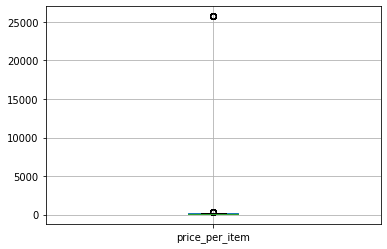

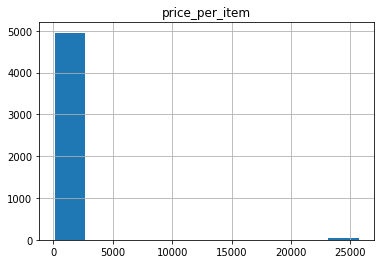

In [10]:
df.boxplot(column='price_per_item')
df.hist(column='price_per_item', bins=10)

Now, I'm no sneakerhead, but $25k seems quite expensive for a pair of kicks. Since each shop only has one item which is the same, I assume the price per items will have the same value across all shop IDs. Therefore, it will be safe to drop all transactions where the price is 25k - the shop that is selling it.

In [11]:
normalized_df = df.loc[df['price_per_item'] != 25725.0]
normalized_df.sort_values('price_per_item', ascending=False)


,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
4882,4883,42,607,704000,2000,credit_card,2017-03-25 04:00:00.000,352.0
4326,4327,42,788,704,2,debit,2017-03-16 23:37:56.791,352.0
1362,1363,42,607,704000,2000,credit_card,2017-03-15 04:00:00.000,352.0
3651,3652,42,830,352,1,credit_card,2017-03-24 22:26:57.542,352.0
1367,1368,42,926,1408,4,cash,2017-03-13 02:38:33.953,352.0
...,...,...,...,...,...,...,...,...
3200,3201,92,858,90,1,cash,2017-03-25 15:14:49.874,90.0
590,591,92,967,90,1,debit,2017-03-28 22:56:22.880,90.0
3187,3188,92,854,90,1,credit_card,2017-03-08 18:16:24.603,90.0
2912,2913,92,942,180,2,debit,2017-03-18 11:43:55.340,90.0


We'll use Grubb's test to see if outliers still exist in the data set, and if so, we must examine if they are justified give the type of data. 

G=max|Yi−Y¯|s

In [12]:
from outliers import smirnov_grubbs as grubbs

gtest_index = grubbs.max_test_outliers(normalized_df['price_per_item'], alpha=0.05)

original_data_outlier_test = grubbs.max_test_outliers(df['price_per_item'], alpha=0.05)

print(
    'Normalized Data: ', gtest_index, 'Original Data: ', original_data_outlier_test
    )

#Grubb's test is great for data with one outlier. This is the case with the "price_per_item" column.


Normalized Data:  [352.0] Original Data:  [25725.0]


It appears there is one outlier remaining in the data. Looking at the charts below, it looks like the price per items form a normal distribution (even slightly skewed to the left) if not for the outlier. 

It's only $350 - reasonable for higher-end shoes these days. I noticed it's corresponding to high order amounts and item counts. I wouldn't be suprised if someone used a "sneaker bot" - [a web crawler that can check out thousands of items within seconds](https://datadome.co/bot-detection/how-to-detect-block-manage-sneaker-bots/) - to purchase that volume.

Regardless, it seems like it can be explained qualitatively and does not require progamatic removal using an interquartile range (as shown below).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d92d1a2d0>]],
      dtype=object)

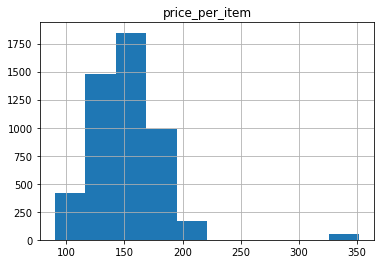

In [13]:
normalized_df.hist(column='price_per_item')

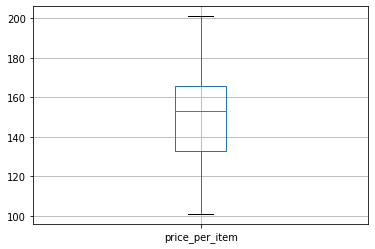

In [14]:
q1 = df.price_per_item.quantile(q=0.25)
q2 = df.price_per_item.quantile(q=0.5)
q3 = df.price_per_item.quantile(q=0.75)
IQR = q3 - q1

iqr_df = df[(df.price_per_item < q2 + IQR * 1.5) & (df.price_per_item > q2 - IQR * 1.5)]
iqr_df.boxplot(column='price_per_item')

#As noted above, this is not required!

**What metric would you report for this dataset?**

In examining the data, it is important to realize that the wide outliers in order amounts represents different types of consumers. It is unrepresentative of the data to take the AOV or even the median order value (MOV) since there are many different buyers with many different preferences. Therefore, I propose that customer's order volumes be categorized by decile order amounts. Different marketing strategies can be applied to consumers in different deciles of order amounts. The metric that should be used should be MOV to adjust for large outliers that may skew the data, but it also should be grouped by decile. 

This way, important e-commerce metrics like customer acquisition cost (CAC) and lifetime value (LTV) can be based on customers of differing spending amounts. Morever, it could lead to more interesting statistical analysis/forecasting such as cluster analysis, K-Nearest Neighbours algorithms, regressions and other machine learning processing. 

For example, lower decile buyers may be more price elastic than uppper decile buyers which can be tested with regressions using income differencing. We could prepare for recessions by stocking up on items that upper decile buyers tend to purchase. 

Metric Calculation: 

Without removing the wide outliers, the 10th decile AOV will be heavily skewed as a result of large order volumes. MOV solves this. 


In [15]:
aov_decile = normalized_df.groupby(pd.qcut(normalized_df.order_amount, 10,labels=range(1, 11)))['order_amount'].mean()
aov_decile_bins = normalized_df.groupby(pd.qcut(normalized_df.order_amount, 10))['order_amount'].mean()
aov_decile_bins

order_amount
(89.999, 133.0]        120.684803
(133.0, 156.0]         146.781853
(156.0, 176.0]         165.726872
(176.0, 236.0]         200.560784
(236.0, 284.0]         266.580645
(284.0, 320.0]         305.991507
(320.0, 354.0]         339.237354
(354.0, 435.0]         390.955975
(435.0, 528.0]         481.347656
(528.0, 704000.0]    26141.377399
Name: order_amount, dtype: float64

In [16]:
mov_decile = normalized_df.groupby(pd.qcut(normalized_df.order_amount, 10,labels=range(1, 11)))['order_amount'].median()
mov_decile_bins = normalized_df.groupby(pd.qcut(normalized_df.order_amount, 10))['order_amount'].median()
mov_decile_bins

order_amount
(89.999, 133.0]      127
(133.0, 156.0]       147
(156.0, 176.0]       164
(176.0, 236.0]       195
(236.0, 284.0]       266
(284.0, 320.0]       306
(320.0, 354.0]       338
(354.0, 435.0]       390
(435.0, 528.0]       480
(528.0, 704000.0]    612
Name: order_amount, dtype: int64

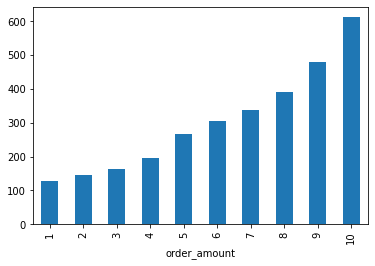

In [17]:
#Plot:
mov_decile.plot(kind='bar')

**Question 2**
a) How many orders were shipped by Speedy Express in total?

Answer: 54

In [18]:
'''
SELECT COUNT(*)
FROM Orders AS o, Shippers AS s
WHERE o.ShipperId = s.ShipperId AND ShipperName = "Speedy Express"; 
'''

'\nSELECT COUNT(*)\nFROM Orders AS o, Shippers AS s\nWHERE o.ShipperId = s.ShipperId AND ShipperName = "Speedy Express"; \n'

b) What is the last name of the employee with the most orders?

Answer: Handel

In [19]:
'''
SELECT c.CustomerName, COUNT(*) AS Count
FROM Orders AS o, Customers AS c
WHERE o.CustomerID = c.CustomerID
GROUP BY o.CustomerID
ORDER BY Count DESC
LIMIT 1;
'''

'\nSELECT c.CustomerName, COUNT(*) AS Count\nFROM Orders AS o, Customers AS c\nWHERE o.CustomerID = c.CustomerID\nGROUP BY o.CustomerID\nORDER BY Count DESC\nLIMIT 1;\n'

c) What product was ordered the most by customers in Germany?

Answer: Boston Crab Meat

In [20]:
'''
SELECT p.ProductID, p.ProductName, SUM(Quantity) AS TotalQuantity
FROM Orders AS o, OrderDetails AS od, Customers AS c, Products AS p
WHERE c.Country = "Germany" AND od.OrderID = o.OrderID AND od.ProductID = p.ProductID AND c.CustomerID = o.CustomerID
GROUP BY p.ProductID
ORDER BY TotalQuantity DESC
LIMIT 1;
'''

'\nSELECT p.ProductID, p.ProductName, SUM(Quantity) AS TotalQuantity\nFROM Orders AS o, OrderDetails AS od, Customers AS c, Products AS p\nWHERE c.Country = "Germany" AND od.OrderID = o.OrderID AND od.ProductID = p.ProductID AND c.CustomerID = o.CustomerID\nGROUP BY p.ProductID\nORDER BY TotalQuantity DESC\nLIMIT 1;\n'